In [1]:
from skreducedmodel.reducedbasis import ReducedBasis, error
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import numpy as np
import optuna 

# Load Data

In [2]:
# physical points
times = np.linspace(-2750, 100, 28501)

# training set
filepath_train = "../../data/2d-complex-q100xchi30-total3000.npy"
train = np.load(filepath_train)  
qs_train = np.linspace(1, 8, 100)
chis_train = np.linspace(-0.8, 0.8, 30)
parameters_train = np.array([(q, chi) for q in qs_train for chi in chis_train])


# validation set
filepath_valid = "../../data/2d-complex-q50xchi15-total750.npy"
valid = np.load(filepath_valid) 
qs_valid = np.linspace(1, 8, 50)
chis_valid = np.linspace(-0.8, 0.8, 15)
parameters_valid = np.array([(q, chi) for q in qs_valid for chi in chis_valid])

# test set
filepath_test = "../../data/2d-complex-q30xchi12-total360.npy"
test = np.load(filepath_test)
qs_test = np.linspace(1, 8, 30)
chis_test = np.linspace(-0.8, 0.8, 12)
parameters_test = np.array([(q, chi) for q in qs_test for chi in chis_test])

# Optimize

In [3]:
from objective import Objective

hyperparameters = {"nmax" : [10, 25],
                   "lmax" : [0, 10],
                   "q_index" : [0, qs_train.shape[0] - 1],
                   "chi_index" : [0, chis_train.shape[0] - 1]}

objective = Objective(times=times, 
                      train=train, 
                      valid=valid, 
                      parameters_train=parameters_train, 
                      parameters_valid=parameters_valid, 
                      hyperparameters= hyperparameters)

study_name = f"2DTPE-ts{train.shape[0]}-vs{valid.shape[0]}"

study = optuna.create_study(study_name=study_name,
                                storage="sqlite:///2d-studies.db", 
                                load_if_exists=True, 
                                sampler=TPESampler(multivariate=True, seed=12))

study.optimize(objective, n_trials=20, gc_after_trial=True)

c:\Users\eliaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\samplers\_tpe\sampler.py:282: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-07-05 16:53:05,651] Using an existing study with name '2DTPE-ts3000-vs750' instead of creating a new one.


# Best hyperparameters Found

In [4]:
best_params = study.best_params; 
for param, value in best_params.items():
    print(f"Best {param} = {value}") 
    # the best seed is an index
print(f"Best Validation Error {study.best_value:.3e}")

Best chi_index = 18
Best lmax = 4
Best nmax = 25
Best q_index = 99
Best Validation Error 1.990e-05


In [18]:
from objective import get_global_index

indices_size = {"q_index" : qs_train.size, "chi_index": chis_train.size}
best_indices = {"q_index" : best_params["q_index"], "chi_index" : best_params["chi_index"]}
best_seed_index = get_global_index(indices_size, best_indices)

one = best_params["q_index"]*chis_train.size + best_params["chi_index"]

print(one, best_seed_index)

2988 2988


### Test Error

In [5]:
from objective import get_global_index

# obtain best global seed index from other indices
indices_size = {"q_index" : qs_train.size, "chi_index": chis_train.size}
best_indices = {"q_index" : best_params["q_index"], "chi_index" : best_params["chi_index"]}
best_seed_index = get_global_index(indices_size, best_indices)

# build reduced basis
rb_best = ReducedBasis(index_seed_global_rb=best_seed_index, 
                       lmax=best_params["lmax"], 
                       nmax=best_params["nmax"])
rb_best.fit(train, parameters_train, times)

# evaluate rb with test set
projections_test = []
for h_t, q_t in zip(test, parameters_test):
    projections_test.append(rb_best.transform(h_t, q_t))
projections_test = np.asarray(projections_test)
test_errors = []

for h_proy, h_test in zip(projections_test, test):
    test_errors.append(error(h_proy, h_test, times))

print(f"Test Error (Max projection error) = {max(test_errors)}")

Test Error (Max projection error) = 4.751429285290395e-05


# Visualize Optimization Results

### Hyperparameter Importances

In [6]:
optuna.visualization.plot_param_importances(study)

In [7]:
# dataframe with trials
db = study.trials_dataframe()

In [8]:
db = db.dropna()

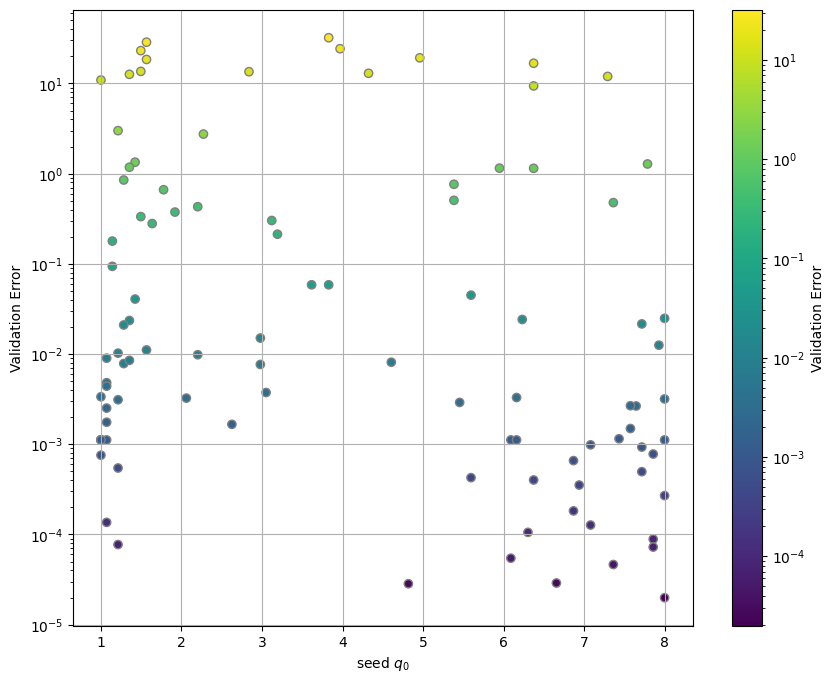

In [9]:
# seed
from matplotlib import colors

x = qs_train[db.params_q_index]
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"seed $q_0$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

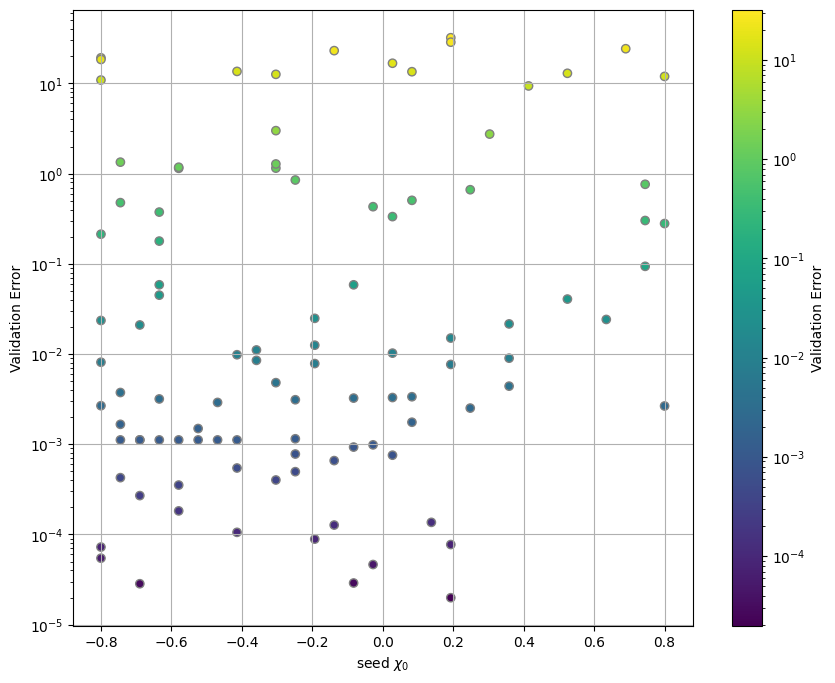

In [10]:
# seed
from matplotlib import colors

x = chis_train[db.params_chi_index]
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"seed $\chi_0$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

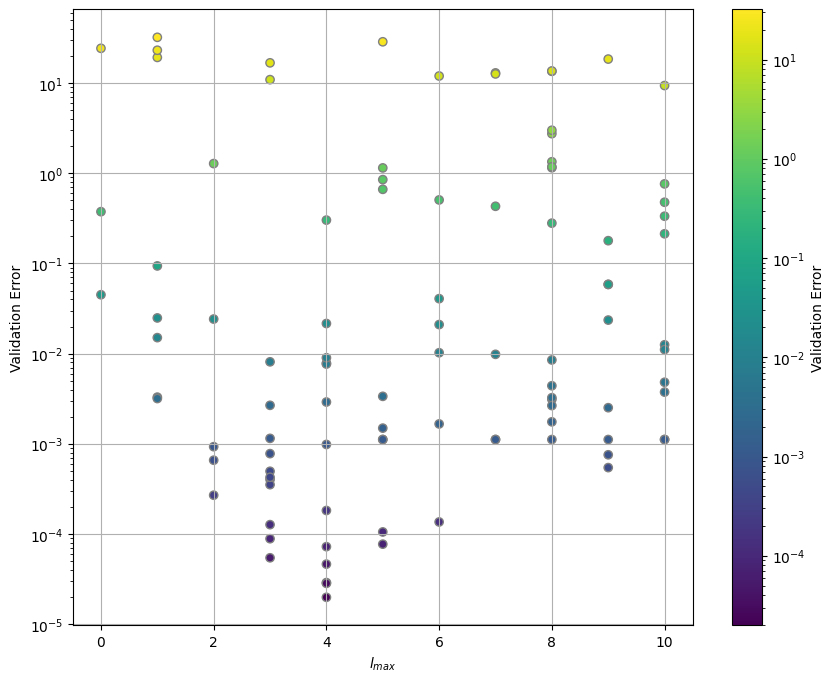

In [11]:
# seed
from matplotlib import colors

x = db.params_lmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$l_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

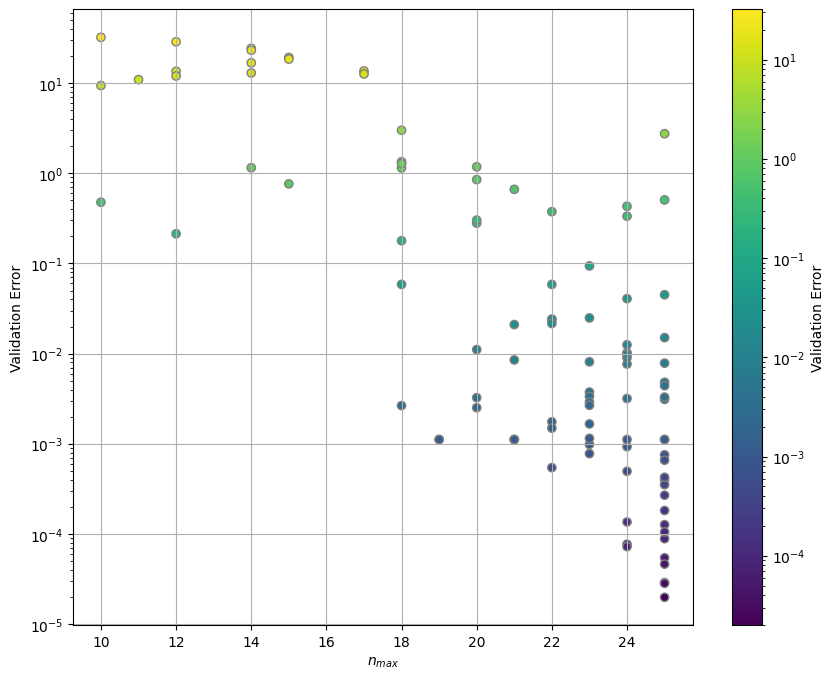

In [12]:
# seed
from matplotlib import colors

x = db.params_nmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$n_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

### Evolution of Validation Error

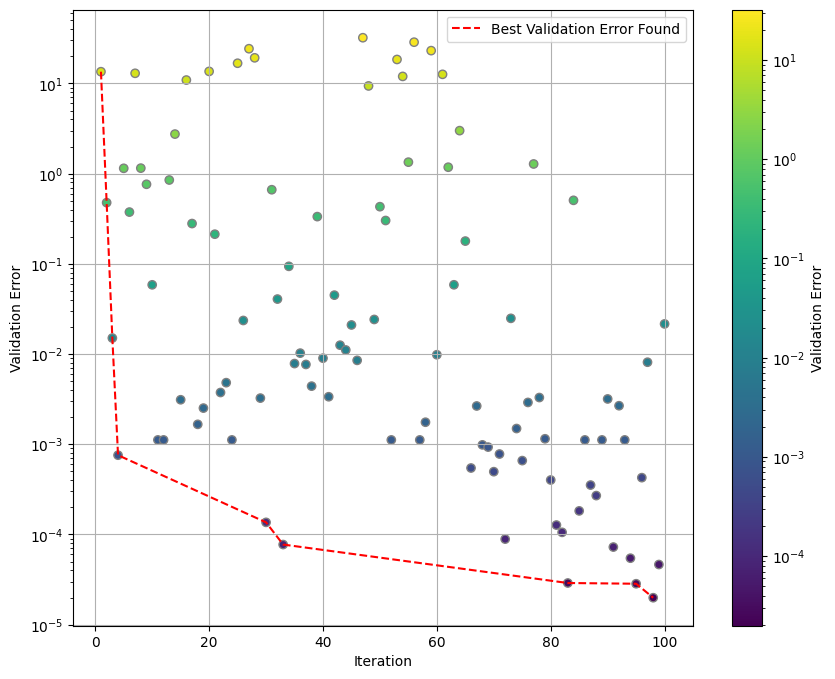

In [13]:
from matplotlib import colors

x = np.array(db.number)
y = np.array(db.value)

min_errs = [y[0]]
min_errs_it = [x[0]]
for i, err in enumerate(y):
    if err <= min(min_errs):
        min_errs.append(err)
        min_errs_it.append(x[i])

norm = colors.LogNorm(y.min(), y.max())
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=y, edgecolors="gray",norm=norm)
plt.plot(min_errs_it, min_errs, "r--", label="Best Validation Error Found")
plt.grid()
plt.colorbar(label="Validation Error")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Validation Error")
plt.legend()

### Evolution of Hyperparameters

Text(0, 0.5, '$l_{max}$')

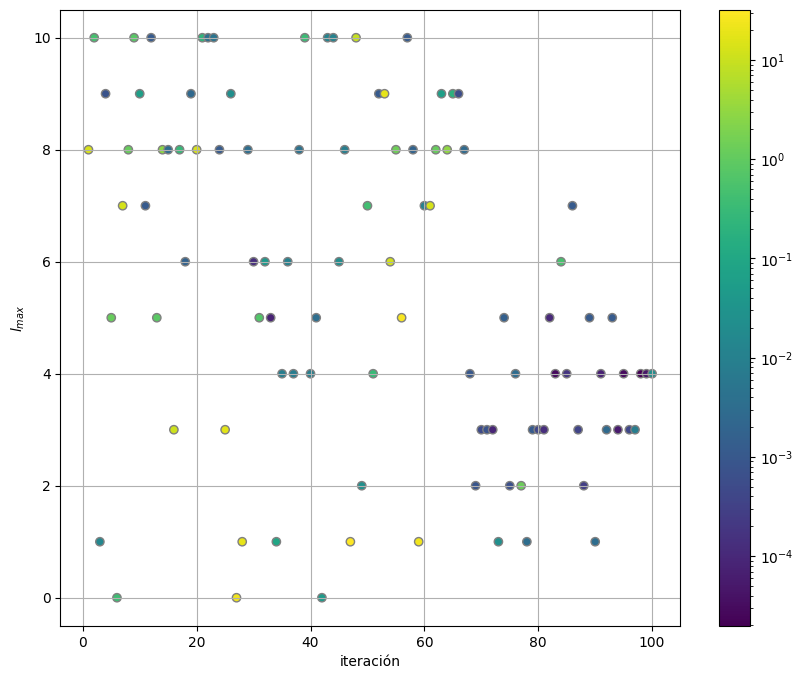

In [14]:
# lmax
x = db.number
y = db.params_lmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("iteración")
plt.ylabel(r"$l_{max}$")

Text(0, 0.5, '$n_{max}$')

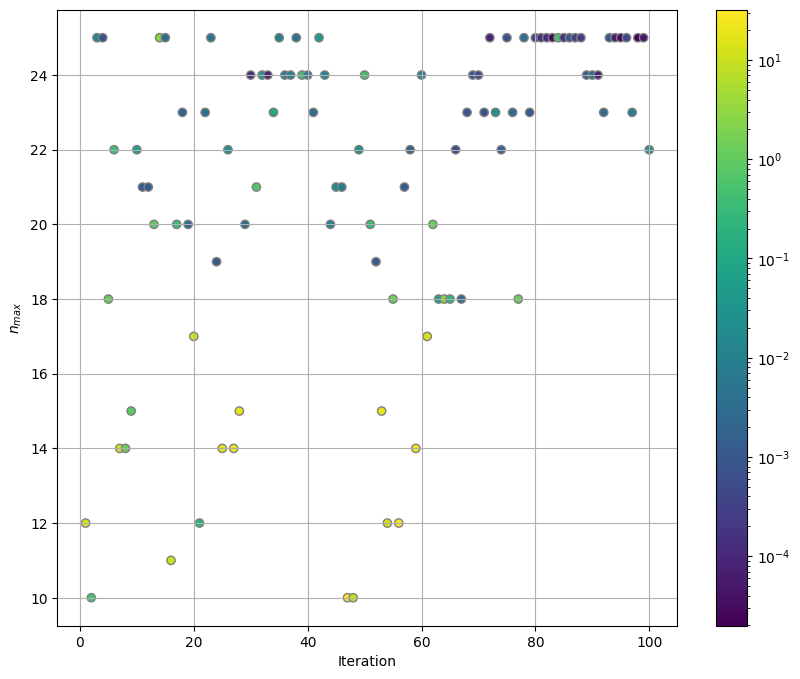

In [15]:
# n max
x = db.number
y = db.params_nmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"$n_{max}$")

Text(0, 0.5, 'seed $q_0$')

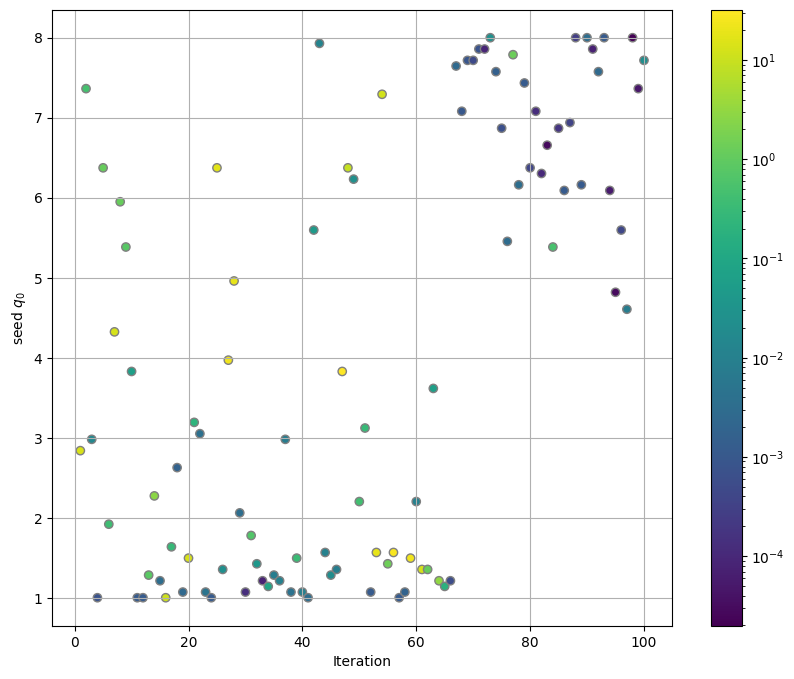

In [16]:
# seed q0
x = db.number
y = qs_train[db.params_q_index]

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"seed $q_0$")

Text(0, 0.5, 'seed $q_0$')

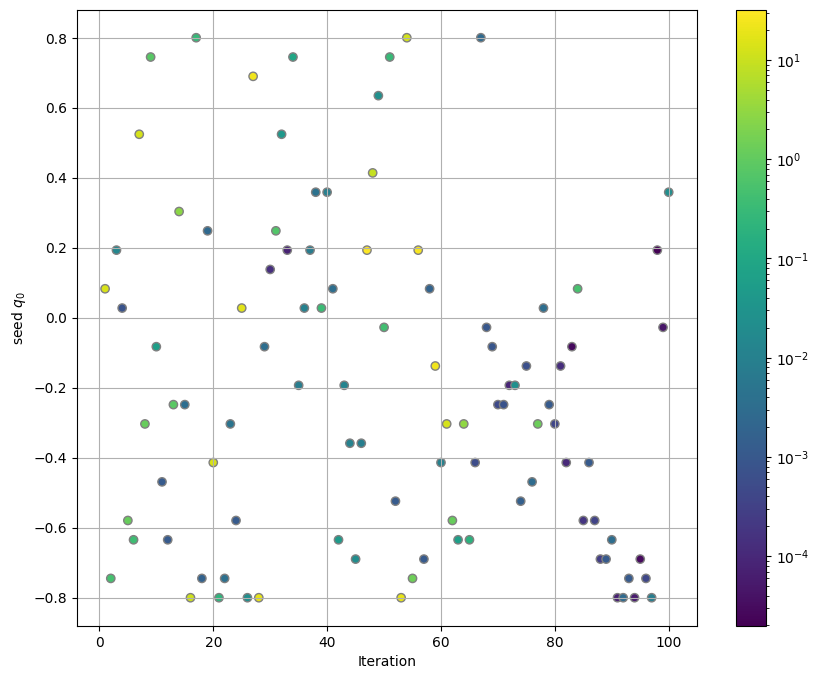

In [17]:
# seed chi0
x = db.number
y = chis_train[db.params_chi_index]

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"seed $q_0$")